Digital Signal Processing

Project - Tracking R of COVID-19 using Kalman Filter

Group Members:

1. Navami Kairanda (Enrollment Number:2577665)
2. Pankhuri Vanjani (Enrollment Number:7009617)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pdb
import os
import sys
from matplotlib.dates import DateFormatter

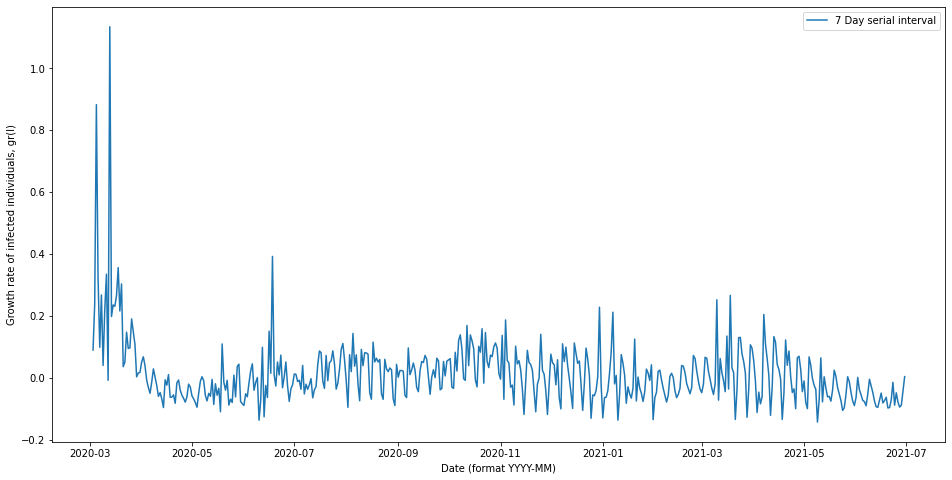

In [2]:
#2.1
#2.1.2
days_infectious = 7
gamma = 1 / float(days_infectious) #transition rate from infected to recovered

random_seed = 12345
np.random.seed(random_seed)

#init_date = '2020-03-01'
#end_date = '2021-06-30' 

population_DE = 83160000 # 83.16 millions in 2020
input_folder = '.'
output_folder = '.'

def construct_dataset(file_name, var_name):
    """Convenience function for constructing
    a clean Pandas dataframe from the CSV
    files provided by JH CSSE on their Github
    repo
    
    Args:
        file_name (str): File name / URL of CSV file
        var_name (name): Variable name
    
    Returns:
        df: Dataframe
    """
    df = pd.read_csv(file_name)
    del df['Lat'], df['Long']
    
    # Melt to long format
    df = pd.melt(df, 
                 id_vars = ['Country/Region'], 
                 value_vars = list(df.columns.values[2:]))
    df.rename(columns = {'variable': 'Date',
                         'value': var_name},
              inplace = True)
    return df

# Read in data on total cases
df = construct_dataset(file_name = '{}/DE_Confirmed.csv'.format(input_folder), var_name = 'total_cases')

# Merge in recovered cases and deaths
for file_name, var_name in zip(['{}/DE_Recovered.csv'.format(input_folder), 
                                '{}/DE_Dead.csv'.format(input_folder)],
                               ['total_recovered', 'total_deaths']):
    df_temp = construct_dataset(file_name = file_name, 
                                var_name = var_name)
    df = pd.merge(df, df_temp, 
                  on = ['Country/Region', 'Date'], 
                  how = 'left')

# Clean up the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df.reset_index(inplace = True)
del df['index']

# Sort by date
df.sort_values(by = ['Date'], ascending = True,
               inplace = True)

# Construct derived flow variables (new cases / 
# recoveries / deaths)
for var_name in ['cases', 'recovered', 'deaths']:
    df['new_{}'.format(var_name)] = (df['total_{}'.format(var_name)] 
                                     - df.shift()['total_{}'.format(var_name)])

# Construct number of infected
df['infected_{}'.format(days_infectious)] = np.nan
for country in df['Country/Region'].unique():
    mask = df['Country/Region'] == country
    df_country = df.loc[mask, ].copy().reset_index()
    T = df_country.shape[0]
    # Initialize number of infected
    infected = np.zeros(T) * np.nan
    infected[0] = df_country['total_cases'][0]

    # Main loop
    for tt in range(1, T):
        # Calculate number of infected recursively;
        # In the JH CSSE dataset, there are some
        # data problems whereby new cases are occasionally
        # reported to be negative; in these case, take zero
        # when constructing time series for # of invected,
        # and then change values to NaN's later on
        infected[tt] = ((1 - gamma) * infected[tt - 1] 
                        + np.maximum(df_country['new_cases'][tt], 0.0))
    df.loc[mask, 'infected_{}'.format(days_infectious)] = infected

# Calculate growth rate of infected
df['gr_infected_{}'.format(days_infectious)] = ((df['infected_{}'.format(days_infectious)] 
    / df.shift(1)['infected_{}'.format(days_infectious)]) - 1)

mask = df.shift(1)['infected_{}'.format(days_infectious)] == 0.0
df.loc[mask, 'gr_infected_{}'.format(days_infectious)] = np.nan

# Remove initial NaN values for growth rates
df['days_since_min_cases'] = range(T)
mask = df['days_since_min_cases'] >= 1
df = df.loc[mask, ]
del df['days_since_min_cases']

# Save final dataset
df.to_csv('{}/DE_Dataset.csv'.format(output_folder), index = False)

plt.figure(figsize=(16, 8))  
gr_infected = np.array(df['gr_infected_{}'.format(days_infectious)])      
df.set_index(['Date'],inplace=True)

plt.plot(df.index, gr_infected, label = "7 Day serial interval") #TODO date format, 4-day growth rate
plt.ylabel("Growth rate of infected individuals, gr(I)")
plt.xlabel("Date (format YYYY-MM)")
plt.legend()
plt.savefig('gr.png')


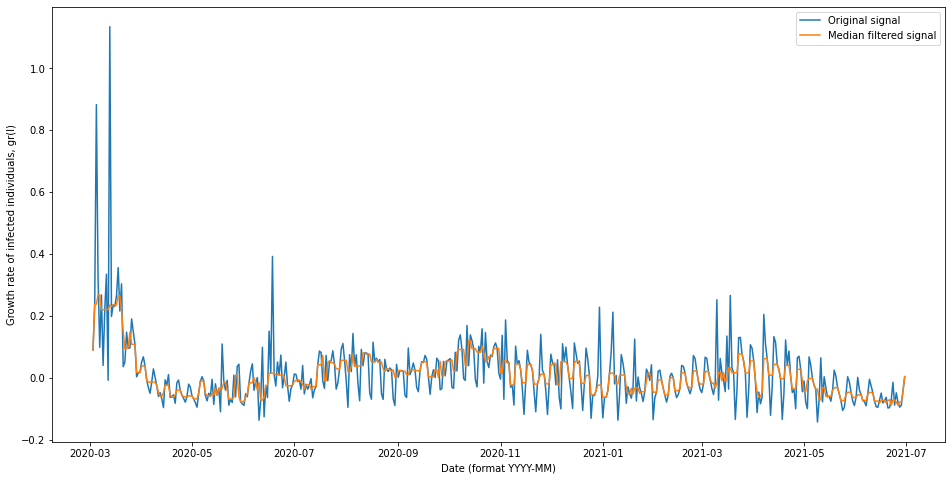

In [3]:
#2.1.3
def median_filter(signal, window_size, stride = 1):
    nrows = ((signal.size - window_size)//stride) + 1
    n = signal.strides[0]
    strided_2d_signal = np.lib.stride_tricks.as_strided(signal, shape = (nrows, window_size), strides=(stride * n, n))
    filtered_signal = np.median(strided_2d_signal, axis=1)
    filtered_signal = np.concatenate([[signal[0]], [signal[1]], filtered_signal, [signal[-2]], [signal[-1]]])
    return filtered_signal

window_size = 5 #TODO tune this parameter
gr_infected_filtered = median_filter(gr_infected, window_size)

plt.figure(figsize=(16, 8))  
plt.plot(df.index, gr_infected, label = "Original signal") 
plt.plot(df.index, gr_infected_filtered, label = "Median filtered signal") 
plt.ylabel("Growth rate of infected individuals, gr(I)")
plt.xlabel("Date (format YYYY-MM)")
plt.legend()
plt.savefig('median_filter.png')

#from scipy import signal
#gr_infected_filtered_scipy = signal.medfilt(gr_infected, window_size)
#np.linalg.norm(gr_infected_filtered_scipy - gr_infected_filtered)

df['gr_infected_filtered'] = gr_infected_filtered

var_gr_infected = np.var(gr_infected)
var_gr_infected_filtered = np.var(gr_infected_filtered)
var_epsilon = (2 * window_size) * (var_gr_infected - var_gr_infected_filtered) / (2 * window_size - math.pi) 
std_epsilon = math.sqrt(var_epsilon)

# Save final dataset
df.to_csv('{}/DE_Dataset.csv'.format(output_folder), index = False)

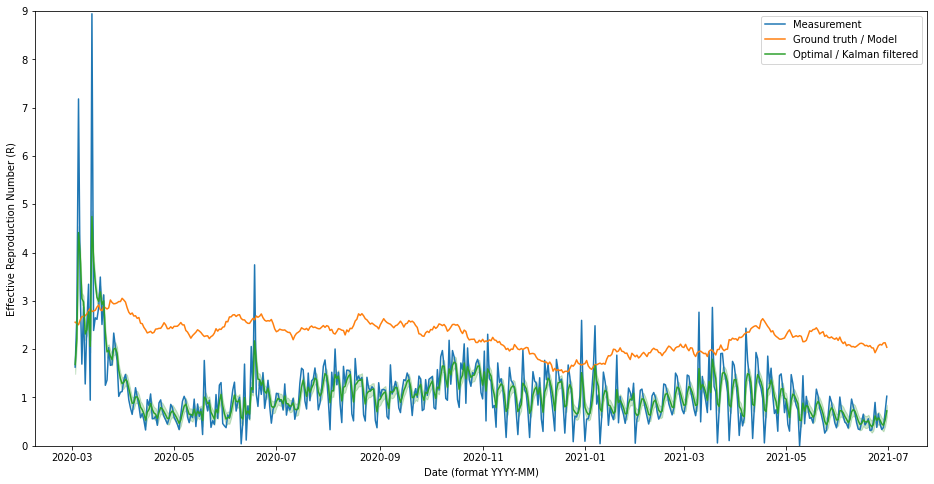

In [4]:
#2.1.4
def addNoise(cs, sigma):
    '''
    sigma: standard deviation of noise distribution
    ns: noisy output signal
    '''
    rn = np.random.normal(0.0, sigma)
    ns = cs + rn
    return ns


def calcP_prior(P, A, Q):
    '''
    P: old process covariance matrix
    A: state transition matrix
    Q: process noise(perturbation) covariance matrix
    Pn: new process covariance matrix 
    '''
    row, col = np.shape(A)
    Pn = np.zeros((row, col))
    PAt = np.matmul(P, np.transpose(A))
    Pn = np.matmul(A, PAt) + Q
    return Pn


def calcK(P, C, R):
    '''
    Calculate Kalman gain to mix process with measurement
    
    Parameters: 
        P: apriori process covariance matrix
        C: transformation matrix to map parameters to measurment domain
        R: measurement noise(error) covariance matrix
    
    Returns:
        Pn: new process covariance matrix 
    '''
    row, col = np.shape(P)
    K = np.zeros((row, col))
    PCt = np.matmul(P, np.transpose(C))
    CPCtpR = np.matmul(C, PCt) + R
    K = np.matmul(PCt, np.linalg.inv(CPCtpR)) 
    return K

def calcEst(mdl, mes, K, C): 
    '''
    Calculate estimated state as a mix of process and measurement
    mdl: predicted/model state vector (according to theoretical formulas)
    mes: measurement state vector (containing measurement error)
    C: transformation matrix to map state parameters to measurement domain
    xh: xhat estimated state vector based on Kalman gain
    '''
    z = mes - np.matmul(C, mdl)
    Kz = np.matmul(K, z)
    xh = mdl + Kz
    return xh

def calcP_posterior(P, K, C):
    '''
    P: old process covariance matrix
    K: 
    C: transformation matrix to map state parameters to measurement domain
    Pn: new process covariance matrix 
    '''
    row, col = np.shape(P)
    Pn = np.zeros((row, col))
    CP = np.matmul(C, P)
    Pn = P - np.matmul(K, CP)
    return Pn

def gr2R(gr_infected):
    #R = 1 + (1 / gamma) * gr_infected
    R = 1 + days_infectious * gr_infected
    return R

def R2gr(R):
    gr_infected = gamma * (R - 1)
    return gr_infected

# 2.1.4 
R_measured = gr2R(gr_infected) 
# 2.1.5 <-- use this for smoother result
#R_measured = gr2R(gr_infected_filtered)
N = R_measured.shape[0] 

mu_gr_infected_0, sigma_gr_infected_0 = 0.25, 0.15
var_gr_infected_0 = sigma_gr_infected_0 ** 2
#The initial growth rate of the infected individuals can be assumed to be drawn from a distribution of N(0.25, 0.15^2)
gr_infected_0 = np.random.normal(mu_gr_infected_0, sigma_gr_infected_0)
R_0 = gr2R(gr_infected_0)

std_eta = 0.5 * std_epsilon
var_eta = std_eta ** 2

R_model = [] 
R_t = R_0
for _ in range(N):
    R_t = addNoise(R_t, std_eta)
    R_model.append(R_t)
R_model = np.array(R_model)

plt.figure(figsize=(16, 8))        
plt.plot(df.index, R_measured, label = "Measurement")
plt.plot(df.index, R_model, label = "Ground truth / Model")
plt.ylim([0, 9])
plt.ylabel("Effective Reproduction Number (R)") # Effective or basic?
plt.xlabel("Date (format YYYY-MM)") 

A = np.array([[1]]) # state transition matrix, also denoted as F
C = np.array([[1]]) # measurement matrix, also denoted as H
Q = np.array([[var_eta]]) # process noise covariance
R = np.array([[var_epsilon]]) # measurement noise covariance

var_R_0 = (1 / gamma) * var_gr_infected_0
P = np.array([[var_R_0]]) 

R_measured = R_measured[:, np.newaxis]
R_optimal = []
R_optimal_var = []
kalman_gain = []

# Main code -- Kalman filter
xhat = [[R_0]]

for t in range(N):
    # Kalman prediction stage
    xhat = np.matmul(A, xhat)
    P = calcP_prior(P, A, Q)

    # Kalman update stage
    K = calcK(P, C, R)
    kalman_gain.append(np.diagonal(K))
    xhat = calcEst(xhat, R_measured[t], K, C)
    R_optimal.append(xhat)
    P = calcP_posterior(P, K, C)
    R_optimal_var.append(P)
    
R_optimal = np.squeeze(np.array(R_optimal))
R_optimal_var = np.squeeze(np.array(R_optimal_var))
kalman_gain = np.array(kalman_gain)

ci = 2 * np.sqrt(R_optimal_var) # 95% confidence interval = 2 * sigma
plt.plot(df.index, R_optimal, label = "Optimal / Kalman filtered")
plt.fill_between(df.index, (R_optimal-ci), (R_optimal+ci), color='green', alpha=.2)
plt.legend()
plt.savefig('kalman_filter.png')


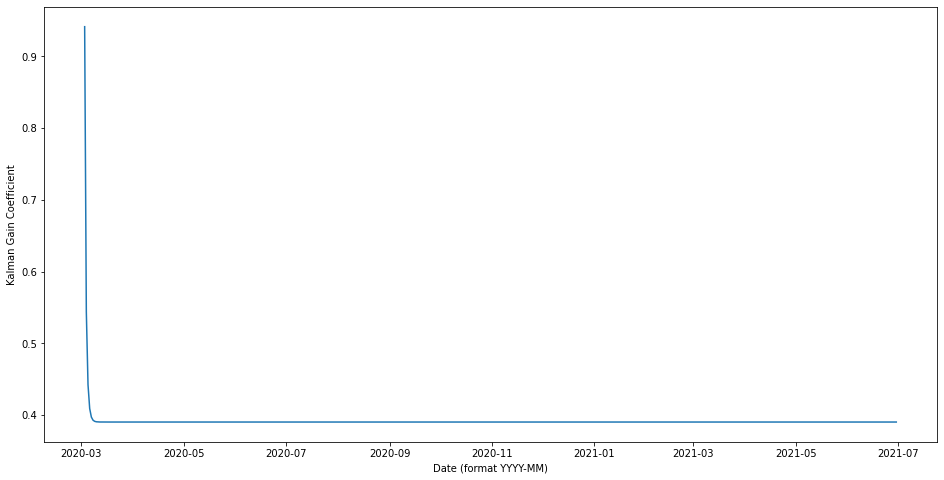

In [5]:
#2.1.6

plt.figure(figsize=(16, 8))   
plt.plot(df.index, kalman_gain) 
plt.xlabel("Date (format YYYY-MM)")
plt.ylabel("Kalman Gain Coefficient")
plt.savefig('kalman_gain.png')

Basic reproduction number: 2.9415763098006544


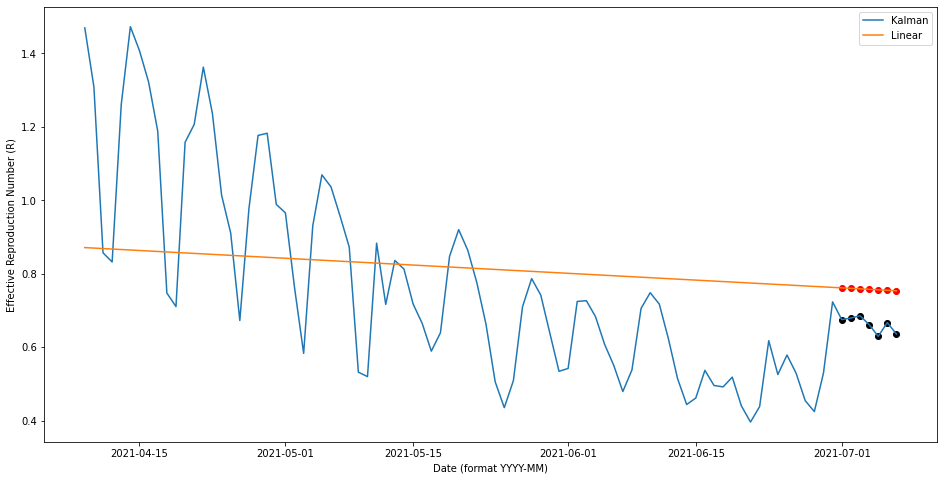

In [6]:
#2.2
future_N = 7 

# Predict R for future days using linear regression
R_optimal_future = []
R_t_optimal = R_optimal[-1]
for _ in range(future_N):
    # Append new date to dataframe
    last_date = df.index[-1] + pd.Timedelta(days=1)
    df.loc[last_date] = 0
    # Append R estimated with Kalman filter 
    R_t_optimal = addNoise(R_t_optimal, std_eta)
    R_optimal_future.append(R_t_optimal)
R_optimal_future = np.array(R_optimal_future)
R_optimal = np.concatenate([R_optimal, R_optimal_future])

# Fit linear regression model on observed data
X = np.array([i for i in range(N)])
Y = gr2R(gr_infected)
A = np.vstack([X, np.ones(len(X))]).T      
m, c = np.linalg.lstsq(A, Y, rcond=None)[0] 

# Predict R for future days using linear regression
X_linear_regress = np.arange(N + future_N)
R_linear_regress = m * X_linear_regress + c

vis_N = 90 # Visualize last 3 months 
plt.figure(figsize=(16, 8))   

plt.plot(df.index[-vis_N:], R_optimal[-vis_N:], label = 'Kalman') 
plt.scatter(df.index[-future_N:], R_optimal[-future_N:], color = 'black')

plt.plot(df.index[-vis_N:], R_linear_regress[-vis_N:], label = 'Linear') 
plt.scatter(df.index[-future_N:], R_linear_regress[-future_N:], color = 'red')

plt.legend()
plt.xlabel("Date (format YYYY-MM)")
plt.ylabel("Effective Reproduction Number (R)")
plt.savefig('future_R.png')

# Eestimate basic reproduction number by the average value of Rt in the first week of the epidemic
R_basic = np.mean(R_optimal[:7])
print('Basic reproduction number: {}'.format(R_basic))  #2.41
